# 3 layer Conv Encoder, LSTM Decoder. 60 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm7'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [9]:
num_input = 60
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, y = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (614, 60, 25)
train_y shape (614, 7, 1)
dev_X shape (77, 60, 25)
dev_y shape (77, 7, 1)
test_X shape (77, 60, 25)
test_y shape (77, 7, 1)


In [19]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=96, kernel_size=3, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(LSTM(200, activation='relu', input_shape=input_shape))
model.add(RepeatVector(num_out))

model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 58, 64)            4864      
_________________________________________________________________
batch_normalization_6 (Batch (None, 58, 64)            256       
_________________________________________________________________
activation_6 (Activation)    (None, 58, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 58, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 56, 96)            18528     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 96)            384       
_________________________________________________________________
activation_7 (Activation)    (None, 56, 96)            0         
__________

In [20]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 614 samples, validate on 77 samples
Epoch 1/200
614/614 [==============================] - 4s 7ms/step - loss: 0.0430 - val_loss: 0.0021
Epoch 2/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0077 - val_loss: 0.0013
Epoch 3/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 4/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 5/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 6/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 7/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 9/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0033 - val_

614/614 [==============================] - 2s 3ms/step - loss: 9.5670e-04 - val_loss: 0.0170
Epoch 80/200
614/614 [==============================] - 2s 3ms/step - loss: 9.9721e-04 - val_loss: 0.0171
Epoch 81/200
614/614 [==============================] - 2s 3ms/step - loss: 7.9935e-04 - val_loss: 0.0153
Epoch 82/200
614/614 [==============================] - 2s 3ms/step - loss: 6.1656e-04 - val_loss: 0.0160
Epoch 83/200
614/614 [==============================] - 2s 3ms/step - loss: 5.5906e-04 - val_loss: 0.0182
Epoch 84/200
614/614 [==============================] - 2s 2ms/step - loss: 5.4773e-04 - val_loss: 0.0169
Epoch 85/200
614/614 [==============================] - 2s 3ms/step - loss: 5.9953e-04 - val_loss: 0.0179
Epoch 86/200
614/614 [==============================] - 2s 3ms/step - loss: 5.9568e-04 - val_loss: 0.0180
Epoch 87/200
614/614 [==============================] - 2s 3ms/step - loss: 7.7828e-04 - val_loss: 0.0364
Epoch 88/200
614/614 [==============================] - 2s 

Epoch 156/200
614/614 [==============================] - 2s 3ms/step - loss: 3.7912e-04 - val_loss: 0.0461
Epoch 157/200
614/614 [==============================] - 2s 3ms/step - loss: 4.0680e-04 - val_loss: 0.0414
Epoch 158/200
614/614 [==============================] - 2s 3ms/step - loss: 3.5784e-04 - val_loss: 0.0477
Epoch 159/200
614/614 [==============================] - 2s 3ms/step - loss: 3.3552e-04 - val_loss: 0.0470
Epoch 160/200
614/614 [==============================] - 2s 3ms/step - loss: 3.8608e-04 - val_loss: 0.0513
Epoch 161/200
614/614 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 0.0330
Epoch 162/200
614/614 [==============================] - 2s 3ms/step - loss: 7.8608e-04 - val_loss: 0.0399
Epoch 163/200
614/614 [==============================] - 2s 3ms/step - loss: 5.7507e-04 - val_loss: 0.0463
Epoch 164/200
614/614 [==============================] - 2s 3ms/step - loss: 4.5705e-04 - val_loss: 0.0470
Epoch 165/200
614/614 [==================

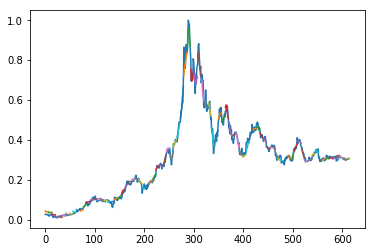

In [21]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

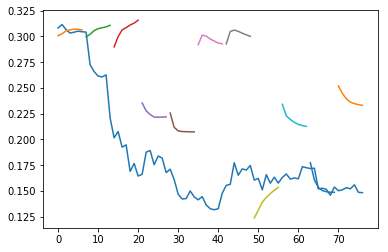

In [22]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

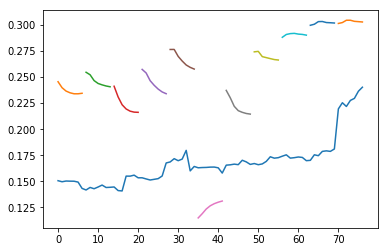

In [23]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [24]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.0003039437494168544
MSE Dev: 0.007040888486417707
MSE Test: 0.008303762310791106


In [25]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.6052202283849919
Acc Dev: 0.5
Acc Test: 0.5131578947368421


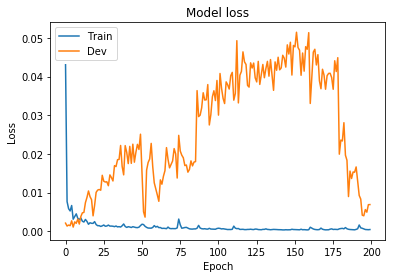

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

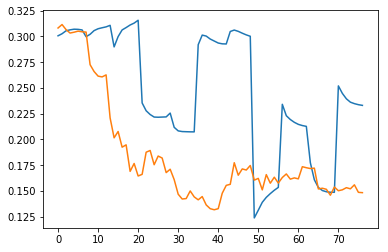

In [27]:
plt.plot(predicted_dev.reshape(-1,1))
plt.plot(true_dev)